# Centrality

I'm going to use Facebook DataSet from SNAP https://snap.stanford.edu/data/egonets-Facebook.html so it's easier to understand what we're looking for.

In [20]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import operator
import timeit

In [109]:
g_fb = nx.read_edgelist('facebook_combined.txt', create_using = nx.Graph(), nodetype = int)

In [110]:
print nx.info(g_fb)
print nx.is_directed(g_fb)

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910
False


In [67]:
spring_pos = nx.spring_layout(g_fb)

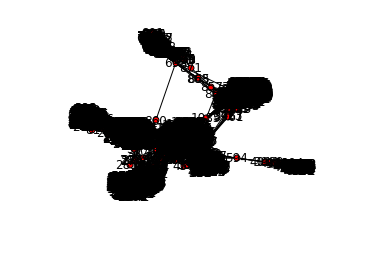

In [68]:
plt.axis('off')
nx.draw_networkx(g_fb, pos = spring_pos, with_lables=False, node_size = 35)

Now let's find the celebrities

In [73]:
dg_centrality = nx.degree_centrality(g_fb)
sorted_dg_centrality = sorted(dg_centrality.items(), key=operator.itemgetter(1), reverse=True)
sorted_dg_centrality[:10]

[(107, 0.258791480931154),
 (1684, 0.1961367013372957),
 (1912, 0.18697374938088163),
 (3437, 0.13546310054482416),
 (0, 0.08593363051015354),
 (2543, 0.07280832095096582),
 (2347, 0.07206537890044576),
 (1888, 0.0629024269440317),
 (1800, 0.06067360079247152),
 (1663, 0.058197127290737984)]

We can see that the node 107 has the highest degree centrality which means node 107 has the highest number of connected nodes. We can prove this by getting the degree of node 107 to see how many friends of node 107 has

In [77]:
nx.degree(g_fb, [107])

{107: 1045}

Node 107 has 1045 friends and we can divide that by number of nodes to get the normalized degree centrality

In [97]:
float(nx.degree(g_fb, [107]).values()[0]) / g_fb.number_of_nodes()

0.25872740777420156

Degree centrality might be the easiest number to calculate but it only shows the number of nodes connected which in real social network it might not be very useful as you might have a million followers but if the majority of them is bots then the number is not telling anything new.

Now let's try Betweenness which count all of the shortest path going throw each now. This might mean that if you have the highest shortest path going through you, you might be considered as bridge of your entire network.

Nodes with high betweenness are important in communication and information diffusion

In [111]:
from multiprocessing import Pool  
import itertools

In [112]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition

In [113]:
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

In [114]:
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    bet_map = p.map(btwn_pool,
                        zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

Let's try with multiprocesser.

302.816536188
[(107, 0.4805180785560148), (1684, 0.3377974497301947), (3437, 0.23611535735892855), (1912, 0.22929533958687467), (1085, 0.14901509211665434), (0, 0.1463059214744287), (698, 0.11533045020561015), (567, 0.09631033121856315), (58, 0.0843602059079655), (428, 0.0643090623932384)]


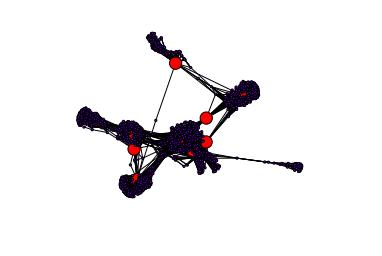

In [120]:
start = timeit.default_timer()
bt = between_parallel(g_fb)
top = 10

max_nodes =  sorted(bt.iteritems(), key = lambda v: -v[1])[:top]
bt_values = [5]*len(g_fb.nodes())
bt_colors = [0]*len(g_fb.nodes())
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
 
plt.axis("off")
nx.draw_networkx(g_fb, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)
stop = timeit.default_timer()
print stop - start
print max_nodes

Now let's try with just one processor

284.876489878


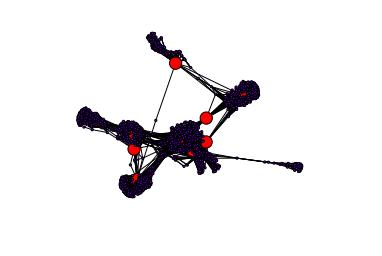

In [121]:
start = timeit.default_timer()
bt = nx.betweenness_centrality(g_fb)
top = 10

max_nodes =  sorted(bt.iteritems(), key = lambda v: -v[1])[:top]
bt_values = [5]*len(g_fb.nodes())
bt_colors = [0]*len(g_fb.nodes())
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
 
plt.axis("off")
nx.draw_networkx(g_fb, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)
stop = timeit.default_timer()
print stop - start
print max_nodes

# iGraph with Facebook Data

In [126]:
from igraph import *

In [127]:
igraph_fb = Graph.Read_Edgelist('facebook_combined.txt', directed=False)

In [128]:
print igraph_fb.summary()

IGRAPH U--- 4039 88234 -- 


In [139]:
def betweenness_centralization(G):
    vnum = G.vcount()
    if vnum < 3:
        raise ValueError("graph must have at least three vertices")
    denom = (vnum-1)*(vnum-2)
 
    temparr = [2*i/denom for i in G.betweenness()]
    return temparr

In [140]:
start = timeit.default_timer()
igraph_betweenness = betweenness_centralization(igraph_fb)
stop = timeit.default_timer()
print stop - start

5.76608204842


In [142]:
print igraph_betweenness[107]

0.480518078556


# Graph_tool with Facebook Data

In [21]:
import sys
sys.path.append('/usr/lib/python2.7/dist-packages')

from graph_tool.all import *
import timeit

In [53]:
show_config()

version: 2.2.44 (commit 178add3a, Thu Jul 2 01:44:54 2015 +0200)
gcc version: 4.8.2
compilation flags: -D_FORTIFY_SOURCE=2 -I/usr/include/python2.7 -I/usr/include -I/usr/lib/python2.7/dist-packages/numpy/core/include -I/usr/lib/python2.7/dist-packages/scipy -I/usr/include -DSPARSEHASH_PREFIX=google -Wall -Wextra -ftemplate-backtrace-limit=0 -O3 -DNDEBUG -std=gnu++11 -ftemplate-depth-250 -Wno-deprecated -Wno-unknown-pragmas -O3 -fvisibility=default -fvisibility-inlines-hidden -fopenmp -I/usr/include -DSPARSEHASH_PREFIX=google -Wl,-Bsymbolic-functions -Wl,-z,relro -L/usr/lib -lpython2.7
install prefix: /usr
python dir: /usr/lib/python2.7/dist-packages
graph filtering: True
openmp: True
uname: Linux ip-172-31-45-186 3.13.0-48-generic #80-Ubuntu SMP Thu Mar 12 11:16:15 UTC 2015 x86_64


In [43]:
graph_tool_fb = Graph(directed=False)

In [44]:
edges = []
with open('facebook_combined.txt', 'r') as f:
    for line in f:
        edge_list = line.split()
        source, target = tuple(edge_list)
        graph_tool_fb.add_edge(source, target)

In [45]:
print graph_tool_fb.num_vertices()
print graph_tool_fb.num_edges()

4039
88234


In [52]:
start = timeit.default_timer()
vertext_betweenness, edge_betweenness = betweenness(graph_tool_fb)
stop = timeit.default_timer()
print stop - start

7.41047000885


In [51]:
vertext_betweenness.a[107]

0.48051807855601453

# Closeness Centrality

Measures by how close a node to the other nodes in the network

# Real data

In [26]:
%matplotlib inline
import pymongo
import networkx as nx
import time
import itertools
import operator

from multiprocessing import Pool
from pymongo import MongoClient

from sweepy.get_config import get_config

config = get_config()

MONGO_URL = config.get('MONGO_URL')
MONGO_PORT = config.get('MONGO_PORT')
MONGO_USERNAME = config.get('MONGO_USERNAME')
MONGO_PASSWORD = config.get('MONGO_PASSWORD')
MONGO_DATABASE = config.get('MONGO_DATABASE')

client = MongoClient(MONGO_URL, int(MONGO_PORT))

db = client[MONGO_DATABASE]
db.authenticate(MONGO_USERNAME, MONGO_PASSWORD)

users = db.users
all_users = users.find()

In [2]:
graph  = nx.DiGraph()

In [3]:
for user in all_users:
    graph.add_node(str(user['id_str']))
    for friend_id in user['friends_ids']:
        if not friend_id in graph:
            graph.add_node(str(friend_id))
        graph.add_edge(str(user['id_str']), str(friend_id))

In [4]:
print nx.info(graph)

Name: 
Type: DiGraph
Number of nodes: 2432155
Number of edges: 5278690
Average in degree:   2.1704
Average out degree:   2.1704


In [4]:
eigen_values = nx.eigenvector_centrality(graph)

In [10]:
sorted_eigen_values = sorted(eigen_values.items(), key=operator.itemgetter(1), reverse=True)
sorted_eigen_values[:10]

[('121817564', 0.09428345177961117),
 ('11107172', 0.07497270265786563),
 ('807095', 0.06812954689012012),
 ('216695058', 0.06667872003411948),
 ('20861943', 0.06605647185989534),
 ('58524428', 0.06489206418816294),
 ('16104258', 0.06282196653973698),
 ('18816166', 0.06144353212620821),
 ('436873679', 0.05926741271555719),
 ('14677919', 0.0592280032725243)]

In [ ]:
closeness_values = nx.closeness_centrality(graph)

In [ ]:
sorted_closeness_values = sorted(closeness_values.items(), key=operator.itemgetter(1), reverse=True)
sorted_closeness_values[:10]

#iGraph

In [1]:
from igraph import *

In [4]:
g = Graph(directed=True)
all_users = users.find({}, { 'id_str' : 1, 'friends_ids' : 1}).batch_size(50)

In [5]:
names = set()
edges = []
print 'Processing first 1000 batch'
for idx, user in enumerate(all_users):
    if idx and not idx % 1000:
        print 'Processing {} batch'.format(idx)
        
    u_id = str(user['id_str'])
    names.add(u_id)
    
    for friend_id in user['friends_ids']:
        f_id = str(friend_id)
        edges.append((u_id, f_id))
        names.add(f_id)

print len(names)
print len(edges)

g.add_vertices(len(names))
g.vs['name'] = list(names)
g.add_edges(edges)

Processing first 1000 batch
Processing 1000 batch
Processing 2000 batch
Processing 3000 batch
Processing 4000 batch
Processing 5000 batch
2794540
6489402


In [6]:
print g.summary()

IGRAPH DN-- 2794540 6489402 -- 
+ attr: name (v)


In [7]:
thisisfusion = g.vs.find(name='121817564')
thisisfusion.degree(type="out")

1907

In [8]:
g.betweenness(thisisfusion)

3225376788.423804

In [29]:
ebs = g.edge_betweenness()
max_eb = max(ebs)
[g.es[idx].tuple for idx, eb in enumerate(ebs) if eb == max_eb]

KeyboardInterrupt: 

# Graph tool

In [3]:
import sys
import os
sys.path.append('/usr/lib/python2.7/dist-packages')

from graph_tool.all import *

In [18]:
g = Graph()
all_users = users.find({}, { 'id_str' : 1, 'friends_ids' : 1}).batch_size(50)
vprop_string = g.new_vertex_property('string')

In [16]:
v = g.add_vertex()
vprop_string[v] = 'id'

In [ ]:
find_vertex(g, g.vertex_properties[''])

In [19]:
print 'Processing first 1000 batch'
for idx, user in enumerate(all_users):
    if idx and not idx % 1000:
        print 'Processing {} batch'.format(idx)
        
    u_id = str(user['id_str'])
    v = g.add_vertex(1)
    
    for friend_id in user['friends_ids']:
        f_id = str(friend_id)
        f = g.add_vertex(1)
        g.add_edge(v, f)

Processing first 1000 batch
Processing 1000 batch
Processing 2000 batch
Processing 3000 batch
Processing 4000 batch
Processing 5000 batch


In [ ]:
graph_draw(g, vertex_text=g.vertex_index, vertex_font_size=12, output_size=(1000, 1000))

10
